# Survival support vector machine

Its main advantage is that it can account for complex, non-linear relationships between features and survival via the so-called kernel trick. A kernel function implicitly maps the input features into high-dimensional feature spaces where survival can be described by a hyperplane. This makes Survival Support Vector Machines extremely versatile and applicable to a wide a range of data. A popular example for such a kernel function is the Radial Basis Function.


Survival analysis in the context of Support Vector Machines can be described in two different ways:

- As a ranking problem: the model learns to assign samples with shorter survival times a lower rank by considering all possible pairs of samples in the training data.

- As a regression problem: the model learns to directly predict the (log) survival time.

In both cases, the disadvantage is that predictions cannot be easily related to standard quantities in survival analysis, namely survival function and cumulative hazard function. Moreover, they have to retain a copy of the training data to do predictions.

Let’s start by taking a closer look at the Linear Survival Support Vector Machine, which does not allow selecting a specific kernel function, but can be fitted faster than the more generic Kernel Survival Support Vector Machine.

Document link: https://scikit-survival.readthedocs.io/en/stable/user_guide/survival-svm.html

## Linear Survival Support Vector Machine

The class sksurv.svm.FastSurvivalSVM is used to train a linear Survival Support Vector Machine. 

The hyper-parameter α>0 determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter r∈[0;1] determines the trade-off between the ranking objective and the regression objective. If r=1 it reduces to the ranking objective, and if r=0 to the regression objective.

The class sksurv.svm.FastSurvivalSVM adheres to interfaces used in scikit-learn and thus it is possible to combine it with auxiliary classes and functions from scikit-learn. In this example, we are going to use the ranking objective (r=1) and GridSearchCV to determine the best setting for the hyper-parameter α on the Veteran’s Lung Cancer data.

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_gbsg2
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
sns.set_style("whitegrid")

We are going to use data from the German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. 

It contains data on 686 women and 8 prognostic factors: 
1. age
2. estrogen receptor (estrec)
3. whether or not a hormonal therapy was administered (horTh)
4. menopausal status (menostat)
5. number of positive lymph nodes (pnodes)
6. progesterone receptor (progrec)
7. tumor size (tsize)
8. tumor grade (tgrade).

The dataset is one of the sksurv.datasets 

In [20]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

# Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.


random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [21]:
n_censored = y.shape[0] - y["cens"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

56.4% of records are censored


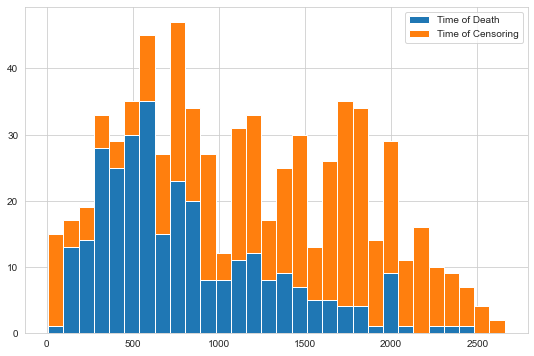

In [22]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["time"][y["cens"]],
                               y["time"][~y["cens"]]),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search.

In [23]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)


Next, we define a function for evaluating the performance of models during grid search. We use Harrell’s concordance index.


In [24]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['cens'], y['time'], prediction)
    return result[0]

The last part of the setup specifies the set of parameters we want to try and how many repetitions of training and testing we want to perform for each parameter setting. In the end, the parameters that on average performed best across all test sets (100 in this case) are selected. GridSearchCV can leverage multiple cores by evaluating multiple parameter settings concurrently (4 jobs in this example).


In [25]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, refit=False,
                   cv=cv)

Finally, start the hyper-parameter search. This can take a while since a total of 13 * 100 = 1300 fits have to be evaluated.


In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(X_train, y_train)

Let’s check what is the best average performance across 100 random train/test splits we got and the corresponding hyper-parameters.



In [27]:
round(gcv.best_score_, 3), gcv.best_params_


(0.676, {'alpha': 0.000244140625})

Finally, we retrieve all 100 test scores for each parameter setting and visualize their distribution by box plots.

In [28]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

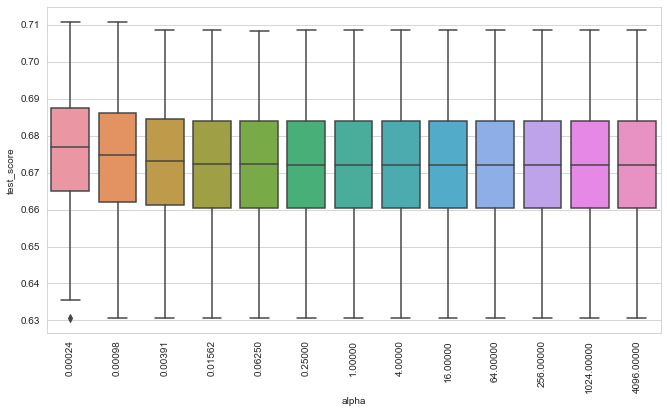

In [29]:
plot_performance(gcv)


We can observe that the model seems to be relative robust with respect to the choice for α for this dataset. Let’s fit a model using the α value that performed best.

In [30]:
estimator.set_params(**gcv.best_params_)
estimator.fit(X_train, y_train)

FastSurvivalSVM(alpha=0.000244140625, max_iter=1000, optimizer='avltree',
                random_state=0, tol=1e-05)

It is important to remember that only if the ranking objective is used exclusively (r=1), that predictions denote risk scores, i.e. a higher predicted value indicates shorter survival, a lower value longer surviv.

Similar to Random Forest result, older patients have higher risk score

In [35]:
# pred = estimator.predict(x.iloc[:2])
# print(np.round(pred, 3))
# print(y[:2])

X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

pred = estimator.predict(X_test_sel)
X_test_sel['risk_score'] = pred
X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,risk_score
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,0.308666
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,0.355324
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,0.110395
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,1.109099
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,0.911167
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,1.126536


# Regression Objective

If the regression objective is used (r<1), the semantics are different, because now predictions are on the time scale and lower predicted values indicate shorter survival, higher values longer survival. Moreover, we saw from the histogram of observed times above that the distribution is skewed, therefore the survival/censoring times will be log-transformed by the FastSurvivalSVM internally, when using a r<1.

Let’s fit a model using the regression objective (r=0) and compare its performance to the ranking model from above.

In [47]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(X_train, y_train)

cindex = concordance_index_censored(
    y_train['cens'],
    y_train['time'],
    -ref_estimator.predict(X_train),  # flip sign to obtain risk scores
)
print(round(cindex[0], 4))

0.5596


Note that concordance_index_censored expects risk scores, therefore, we had to flip the sign of predictions. The resulting performance of the regression model is comparable to the of the ranking model above.

In [48]:
# pred = ref_estimator.predict(x.iloc[:2])
# print(np.round(pred, 3))
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

pred = ref_estimator.predict(X_test_sel)
X_test_sel['time_to_event'] = pred
X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,time_to_event
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,226.518585
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,249.856195
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,277.357137
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,1793.707795
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,6924.359510
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,2091.952619


# Kernel Survival Support Vector Machine¶

The Kernel Survival Support Vector Machine is a generalization of the Linear Survival Support Vector Machine that can account for more complex relationships between features and survival time, it is implemented in sksurv.svm.FastKernelSurvivalSVM. The disadvantage is that the choice of kernel function and its hyper-parameters is often not straightforward and requires tuning to obtain good results.

In this example, we are going to use the clinical kernel, because it is able to distinguish between continuous, ordinal, and nominal attributes. As this is a custom kernel function, we first need to pre-compute the kernel matrix.


In [49]:
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

In [51]:
kernel_matrix = clinical_kernel(X_train)


As with the Linear Survival Support Vector Machine above, we are going to determine the optimal α value by using GridSearchCV.

In [52]:
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model,
                    n_jobs=4, refit=False,
                    cv=cv)

Note that when using a custom kernel, we do not pass the original data (data_x) to the fit function, but the pre-computed, square kernel matrix.


In [53]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
kgcv = kgcv.fit(kernel_matrix, y_train)

Now, print the best average concordance index and the corresponding parameters.


In [54]:
round(kgcv.best_score_, 3), kgcv.best_params_


(0.684, {'alpha': 0.015625})

Finally, we visualize the distribution of test scores obtained via cross-validation.

We can see that the choice of α is much more important here, compared to the Linear Survival Support Vector Machine. Nevertheless, the best performance is below that of the linear model, which illustrates that choosing a good kernel function is essential, but also a non-trivial task.

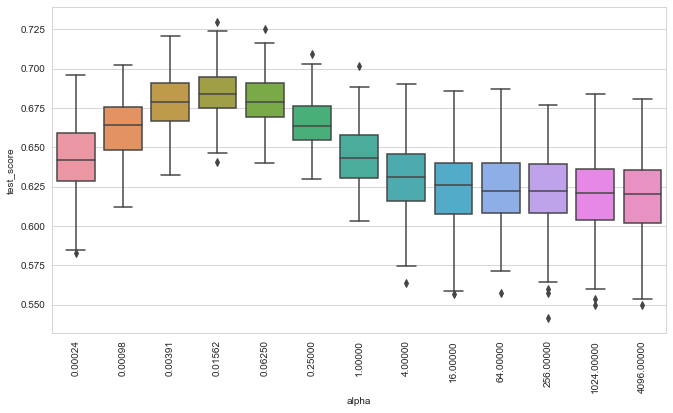

In [55]:
plot_performance(kgcv)


In [57]:
estimator.set_params(**kgcv.best_params_)
estimator.fit(X_train, y_train)

FastSurvivalSVM(alpha=0.015625, max_iter=1000, optimizer='avltree',
                random_state=0, tol=1e-05)

In [58]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

pred = estimator.predict(X_test_sel)
X_test_sel['time_to_event'] = pred
X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,time_to_event
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,0.336953
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,0.383447
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,0.125523
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,1.137493
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,0.926745
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,1.150848


In [61]:
cindex = concordance_index_censored(
    y_test['cens'],
    y_test['time'],
    -ref_estimator.predict(X_test),  # flip sign to obtain risk scores
)
print(round(cindex[0], 4))

0.5934
